In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['Titanic_Data-2.html', 'titanic_data.csv']


* Name - Name of the passenger
* Pcalss- Ticket Class
* Sex - Sex of the passenger
* Age - Age in years
* SibSp - Number of siblings and spouses aboard
* Parch - Number of parents and children aboard
* Ticket - Ticket number
* Fare - Passenger fare
* Cabin - Cabin number 
* Embarked - Port of embarkation ( C=Cherbourg, Q=Queenstown, S=Southampton)

The first thing is to actually look at the data.
We have personal information here in the name feature, but this is public information so that's okay. 

In [2]:
df = pd.read_csv("../input/titanic_data.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

The features name, passenger ID, and ticket aren't going to be of much use here in determining whether a passenger survived. So we're going to just drop those. 
In addition to name, passenger ID, and ticket, sex, cabin, and embarked are all non-numeric features which we'll be exploring later on

In [4]:
drop_rows = ["PassengerId", "Name", "Sex", "Ticket", "Cabin", "Embarked"]
cdf = df.drop(drop_rows, axis=1)

Now let's go ahead and print out the first five rows.  
So now you can see a much cleaner data frame where we only have the continuous features here.

In [5]:
cdf.head()

,Survived,Pclass,Age,SibSp,Parch,Fare
0,0,3,22.0,1,0,7.2500
1,1,1,38.0,1,0,71.2833
2,1,3,26.0,0,0,7.9250
3,1,1,35.0,1,0,53.1000
4,0,3,35.0,0,0,8.0500


Let's look at the shape of the data. It can be seen that under age the count was only  714, whereas it is 891 for the other five features. The reason is that there is missing values with age.

For our Survived feature, which is our target, that's a binary(0 or 1), since it's binary we can use the mean to tell us what percent of people survived in this dataset. Here it tells us 38.4% of people survived. It is always useful to know that when we are doing classification problem.

In [6]:
cdf.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Now let's see which features might be strong indicators of whether somebody survived or not.
One way to do that is to just groupby the two levels of survive, and generate the average value of the other features at those two levels of the target variable.

So the average age of a person that didn't survive is 30.6 and the average age for somebody who did survive is 28.3. 

The average fare for somebody who didn't survive is around 22 dollars, while the average fare for somebody who did survive is over 48 dollars. 

The average Pclass for somebody who didn't survive is around 2.5 (2nd and 3rd class), while the average Pclass for somebody who did survive is over 1.9(1st and 2nd class).

In [7]:
cdf.groupby("Survived").mean()

,Pclass,Age,SibSp,Parch,Fare
Survived,,,,,
0,2.531876,30.626179,0.553734,0.329690,22.117887
1,1.950292,28.343690,0.473684,0.464912,48.395408


We want to understand whether the missing values in age are at random, for instance if it was never reported for certain people, or if it's missing in a systematic way, e.g. they didn't ask the age of anybody in first class. Because this will inform how we handle these missing values. 

People without age reported were less likely to survive, had a higher class number, had fewer parents or children, and a lower fare. So based on all this information, we could theorize that age wasn't recorded for people in the bowels of the ship that maybe were traveling alone. 

But in summary, nothing really jumps out here that would require us to treat these missing values any specific way.

In [8]:
cdf.groupby(df["Age"].isnull()).mean()

,Survived,Pclass,Age,SibSp,Parch,Fare
Age,,,,,,
False,0.406162,2.236695,29.699118,0.512605,0.431373,34.694514
True,0.293785,2.598870,NaN,0.564972,0.180791,22.158567


Let's plot the continuous features which are age and fare.

We can see that, there isn't much difference in age between people that survived and those that did not.

We could see there's a heavy concentration of people between 20 and 30, maybe extending out to 40, but the distribution between survived versus not survived is relatively similar except for the very low end. 

Now let's look at fare. We noticed a fairly drastic difference in the averages. The average is about $48 for those that survived, and about $22 for those that did not.

So fare can probably help us predict whether somebody survived, but it's not quite as cut and dry as the average indicate. The average is likely being impacted by some outliers. 

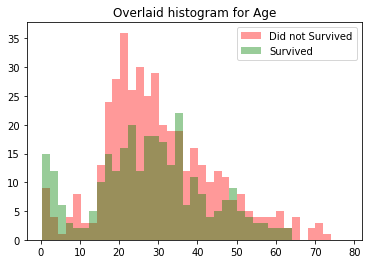

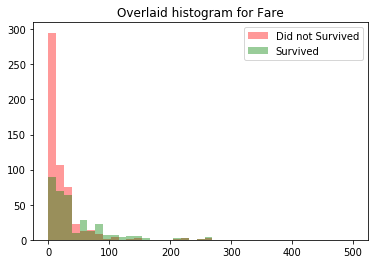

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

for i in ["Age", "Fare"]:
    died = list(cdf[cdf["Survived"]==0][i].dropna())
    survived = list(cdf[cdf["Survived"]==1][i].dropna())
    xmin= min(min(died), min(survived))
    xmax= max(max(died), max(survived))
    width = (xmax-xmin)/40
    sns.distplot(died, color="r", kde=False, bins=np.arange(xmin,xmax,width))
    sns.distplot(survived, color="g", kde=False, bins=np.arange(xmin,xmax,width))
    plt.legend(["Did not Survived", "Survived"])
    plt.title("Overlaid histogram for {}".format(i))
    plt.show()

Now let's look at Pclass, SibSp, and Parch. 
These features are ordinal.

So for first class passengers, roughly 63% of those people survived, and then these vertical bars represent the error.

Better class, first class is more likely to survive than third class.
people with more siblings are also less likely to survive.
those with more parents or children are also less likely to survive.

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 432x288 with 0 Axes>

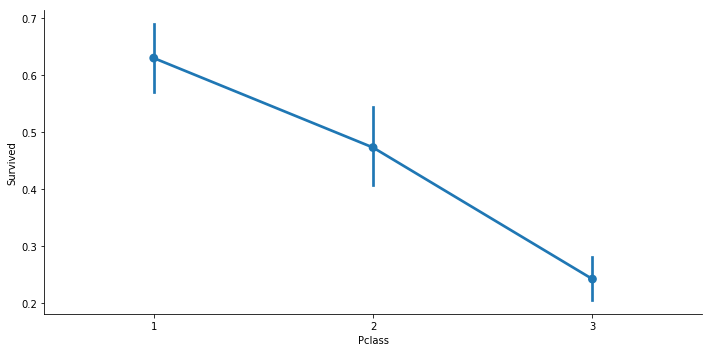

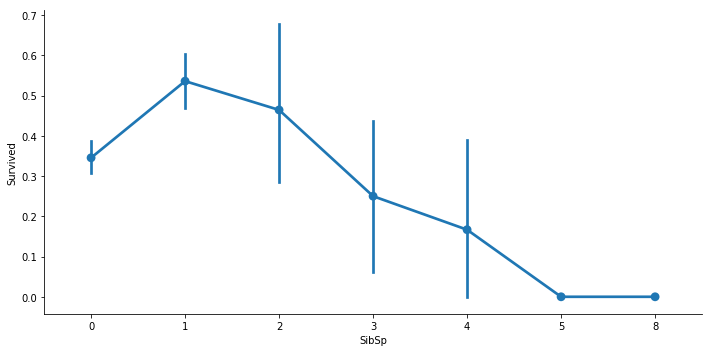

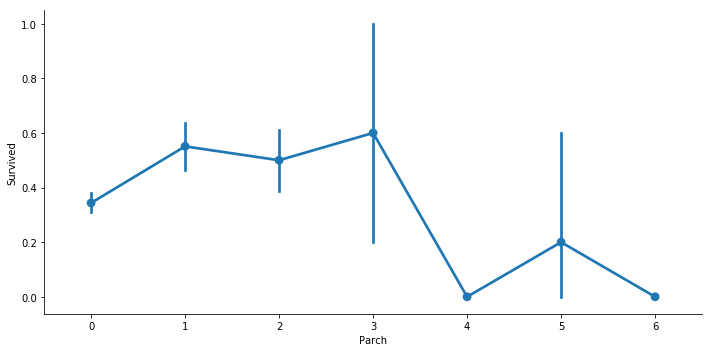

In [10]:
for i, col in enumerate(["Pclass", "SibSp", "Parch"]):
    plt.figure(i)
    sns.catplot(x=col, y="Survived", data=cdf, kind="point", aspect=2)

Now, it seems like SibSp and Parch all have to do with family members aboard, and when you have more, you're less likely to survive. So it seems like perhaps we could merge that into a single feature.

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


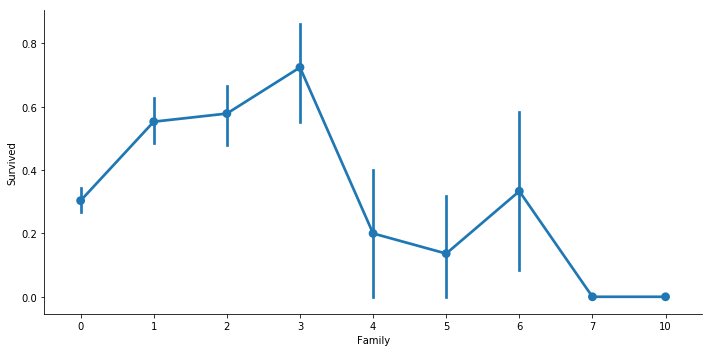

In [11]:
cdf["Family"] = cdf["SibSp"] + cdf["Parch"]
cdf.drop(["SibSp", "Parch"], axis=1, inplace=True)
sns.catplot(x="Family", y="Survived", data=cdf, kind="point", aspect=2)

Let's fill in the missing values in age. We are going to just replace the missing values with average value for that age. This way it satisfies the model by making sure that there's a value in there, but by replacing it with the average value, it's not biasing the model towards one outcome or another. 

In [12]:
cdf["Age"].fillna(cdf["Age"].mean(), inplace=True)
cdf.isnull().sum()

Survived    0
Pclass      0
Age         0
Fare        0
Family      0
dtype: int64

In row 5, we have 29.699, and that's going to be the average value. And you can tell, because the rest of the values are integers, and this one is a float.

In [13]:
cdf.head(10)

,Survived,Pclass,Age,Fare,Family
0,0,3,22.000000,7.2500,1
1,1,1,38.000000,71.2833,1
2,1,3,26.000000,7.9250,0
3,1,1,35.000000,53.1000,1
4,0,3,35.000000,8.0500,0
5,0,3,29.699118,8.4583,0
6,0,1,54.000000,51.8625,0
7,0,3,2.000000,21.0750,4
8,1,3,27.000000,11.1333,2
9,1,2,14.000000,30.0708,1


Now let's explore the categorical features

In [14]:
rows_to_drop = ["PassengerId", "Pclass", "Name", "Age", "SibSp", "Parch", 
                "Fare"]
idf = df.drop(rows_to_drop, axis=1)
idf.head()

,Survived,Sex,Ticket,Cabin,Embarked
0,0,male,A/5 21171,NaN,S
1,1,female,PC 17599,C85,C
2,1,female,STON/O2. 3101282,NaN,S
3,1,female,113803,C123,S
4,0,male,373450,NaN,S


Explore Sex, Cabin and embark

By looking at the info of our data, we can notice that cabin only has 204 non-null features and then embarked only has 889 non-null features while we have 891 non-null features for other features, that means we have alot of missing values for cabin and just a couple for embarked

In [15]:
idf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 5 columns):
Survived    891 non-null int64
Sex         891 non-null object
Ticket      891 non-null object
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: int64(1), object(4)
memory usage: 34.9+ KB


Let's do groupby for cabin to see the missing values.
This is only returning the survived field because the survived field is the only feature left in the data frame that is continuous right now.

We can see over 66% of the people who have non missing cabin values survived, well less than 30% of those who had a missing cabin value survived.

it's very clear that cabin is not missing at random, it's actually very strong indicator whether somebody survived or not. 

So one easy hypothesis here is just that people without an assigned cabin literally don't have a cabin. Maybe they were stuck somewhere in the bows of the ship and that's why so few survived. 

In [16]:
idf.groupby(idf["Cabin"].isnull()).mean()

,Survived
Cabin,
False,0.666667
True,0.299854


So the way we're going to handle that is just create a binary indicator that just says whether a person had a cabin or not. 

In [17]:
idf["Cabin_ind"] = np.where(idf["Cabin"].isnull(), 0, 1)
idf.head()

,Survived,Sex,Ticket,Cabin,Embarked,Cabin_ind
0,0,male,A/5 21171,NaN,S,0
1,1,female,PC 17599,C85,C,1
2,1,female,STON/O2. 3101282,NaN,S,0
3,1,female,113803,C123,S,1
4,0,male,373450,NaN,S,0


Let's plot our categorical feature.

So, looking at this first plot, this says that people without cabins had a 30% survival rate, and those who did have cabins were around 66%. 

We see that more than 70% of the women survived, while only 20% of men survived, so it's really clear that this has really powerful splitting power. 

by looking at the embarked plot, It's unlikely that where people boarded caused them to survive or not, more than likely this correlated with other features that are already being accounted for in our data. For instance, perhaps a higher ratio of men boarded in South Hampton, or maybe more people that boarded in Cherbourg had cabins, and thus were more likely to survive. 

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 432x288 with 0 Axes>

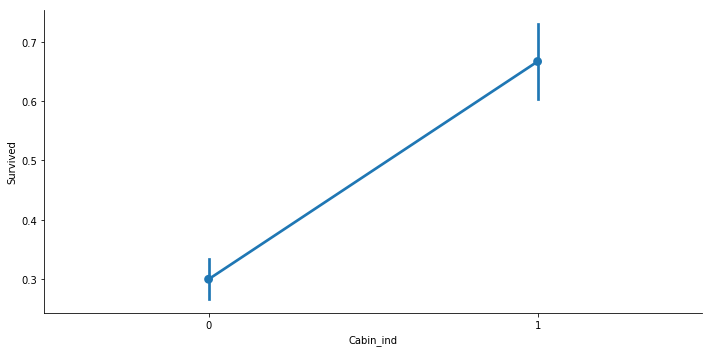

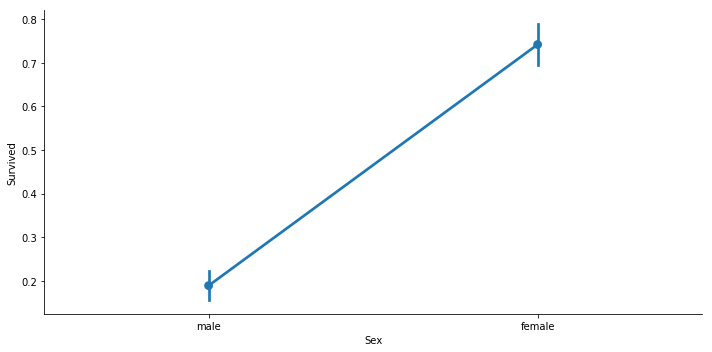

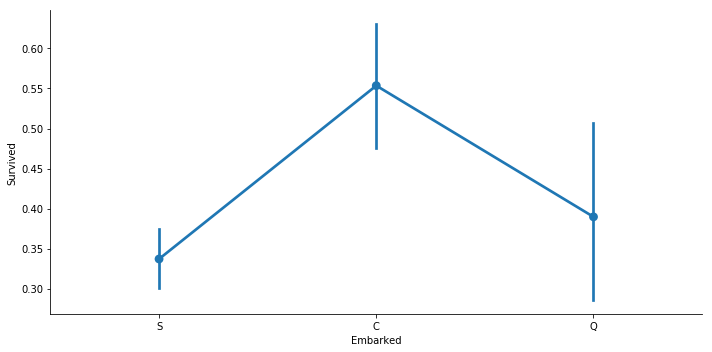

In [18]:
for i, col in enumerate(["Cabin_ind", "Sex", "Embarked"]):
    plt.figure(i)
    sns.catplot(x=col, y="Survived", data=idf, kind="point", aspect=2)

We can actually explore these hypothesis using pivot tables.

so this is telling us that 95 people that boarded in Cherbourg were male while only 73 were female. Now you can see that for Cherbourg and Queenstown the number of men versus women boarding is fairly close, but in South Hampton, you can see that more than double the amount of men boarded as women. 

Given the fact that we know men were much less likely to survive than women, this would explain why South Hampton had the lowest survival rate of all the ports. 

In [19]:
idf.pivot_table("Survived", index="Sex", columns="Embarked", aggfunc="count")

Embarked,C,Q,S
Sex,,,
female,73,36,203
male,95,41,441


let's look at the relationship between port and whether they had cabins or not.

here we can see that for Queenstown and Southampton there're drastically more people without cabins than with cabins. So, for Queenstown there's about fifteen times more people without cabins than with cabins, and for South Hampton there's about three and a half times more people without cabins than with cabins. But, then when we look at Cherbourg, it's relatively close, only about 50% more people had no cabin versus having a cabin. Given that we know people that had cabins were much more likely to survive, this would explain why Cherbourg had a much higher survival rate. 

we have now seen that fewer people from Southampton survived, because so many more men boarded there, and a much higher ratio of people survived from Cherbourg, because so many people that boarded there had cabins. 

In [20]:
idf.pivot_table("Survived", index="Cabin_ind", columns="Embarked", 
                aggfunc="count")

Embarked,C,Q,S
Cabin_ind,,,
0,99,73,515
1,69,4,129


In [21]:
idf.head()

,Survived,Sex,Ticket,Cabin,Embarked,Cabin_ind
0,0,male,A/5 21171,NaN,S,0
1,1,female,PC 17599,C85,C,1
2,1,female,STON/O2. 3101282,NaN,S,0
3,1,female,113803,C123,S,1
4,0,male,373450,NaN,S,0


Let's convert the sex feature into numeric.

In [22]:
gender_num = {"male": 0, "female": 1}
idf["Sex"] = idf["Sex"].map(gender_num)
idf.head()

,Survived,Sex,Ticket,Cabin,Embarked,Cabin_ind
0,0,0,A/5 21171,NaN,S,0
1,1,1,PC 17599,C85,C,1
2,1,1,STON/O2. 3101282,NaN,S,0
3,1,1,113803,C123,S,1
4,0,0,373450,NaN,S,0


the actual Cabin feature is repetitive and unnecessary. We discovered that there are different survival rates for the different levels of the Embarked feature. However, this was not a causal relationship. Other features like percent of men boarding at each port or percent of people that had cabins were the real causal factors, and since those are already accounted for in this model, we can drop the Embarked feature.  

In [23]:
idf.drop(["Cabin", "Embarked"], axis=1, inplace=True)
idf.head()

,Survived,Sex,Ticket,Cabin_ind
0,0,0,A/5 21171,0
1,1,1,PC 17599,1
2,1,1,STON/O2. 3101282,0
3,1,1,113803,1
4,0,0,373450,0


In [24]:
df.drop(["Name", "Ticket", "Embarked"], axis=1, inplace=True)
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin
0,1,0,3,male,22.0,1,0,7.2500,NaN
1,2,1,1,female,38.0,1,0,71.2833,C85
2,3,1,3,female,26.0,0,0,7.9250,NaN
3,4,1,1,female,35.0,1,0,53.1000,C123
4,5,0,3,male,35.0,0,0,8.0500,NaN


Let's add the cleaned features in the actual dataframe.

In [25]:
df["Sex"] = idf["Sex"]
df["Age"] = cdf["Age"]
df["Cabin"] = idf["Cabin_ind"]
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin
0,1,0,3,0,22.0,1,0,7.2500,0
1,2,1,1,1,38.0,1,0,71.2833,1
2,3,1,3,1,26.0,0,0,7.9250,0
3,4,1,1,1,35.0,1,0,53.1000,1
4,5,0,3,0,35.0,0,0,8.0500,0


Now our data is cleaned and ready for modelling and prediction.
let's first split our data into train and test sets.

In [26]:
from sklearn.model_selection import train_test_split
x = df.drop("Survived", axis=1)
y = df["Survived"]

x_train, x_test, y_train, y_test = train_test_split(x, y , test_size=0.33, random_state=42)


Let's look at the shapes of our train and test sets.

In [27]:
for dataset in [y_train, y_test]:
    print(round(len(dataset)/len(x), 2))

0.67
0.33


So we can say around 84% accuracy but depending on the subset trained and tested on, that could be as low as 72% or as high as 85%. 

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
import warnings 
warnings.filterwarnings("ignore", category=FutureWarning)

rf = RandomForestClassifier()
scores = cross_val_score(rf,x, y, cv=5)
scores

array([0.70391061, 0.79888268, 0.8258427 , 0.79775281, 0.82485876])

Let's find the best parameters for our model.
A function just to help us print out the results a little more cleanly. 

In [29]:
def print_result(result):
    print("BEST PARAMS:{}\n".format(result.best_params_))
    
    means = result.cv_results_["mean_test_score"]
    std = result.cv_results_["std_test_score"]
    for mean, std, params in zip(means, std, result.cv_results_["params"]):
        print("{} (+/-{}) for {}".format(round(mean, 3), round(std, 3), params))

Now, it's telling us that the best hyper parameter values are max depth of 20, with 100 estimators. 

In [30]:
parameters = {
    "n_estimators": [5, 50, 100], 
    "max_depth":[2, 10, 20, None]
}

cv = GridSearchCV(rf, parameters, cv=5)
cv.fit(x, y)
print_result(cv)

BEST PARAMS:{'max_depth': 10, 'n_estimators': 50}

0.764 (+/-0.034) for {'max_depth': 2, 'n_estimators': 5}
0.787 (+/-0.037) for {'max_depth': 2, 'n_estimators': 50}
0.782 (+/-0.029) for {'max_depth': 2, 'n_estimators': 100}
0.777 (+/-0.036) for {'max_depth': 10, 'n_estimators': 5}
0.815 (+/-0.043) for {'max_depth': 10, 'n_estimators': 50}
0.807 (+/-0.05) for {'max_depth': 10, 'n_estimators': 100}
0.776 (+/-0.072) for {'max_depth': 20, 'n_estimators': 5}
0.804 (+/-0.059) for {'max_depth': 20, 'n_estimators': 50}
0.809 (+/-0.061) for {'max_depth': 20, 'n_estimators': 100}
0.789 (+/-0.043) for {'max_depth': None, 'n_estimators': 5}
0.808 (+/-0.052) for {'max_depth': None, 'n_estimators': 50}
0.81 (+/-0.036) for {'max_depth': None, 'n_estimators': 100}


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


So we're going to start with the best hyper parameter combination that we found. 

In [31]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
rf = RandomForestClassifier(n_estimators=100, max_depth=20)
rf.fit(x_train,y_train)
y_hat = rf.predict(x_test)
print("The accuracy score: ",accuracy_score(y_test, y_hat))


The accuracy score:  0.8033898305084746


In [32]:
print("The f1_score:\n", classification_report(y_test, y_hat))

The f1_score:
               precision    recall  f1-score   support

           0       0.79      0.91      0.85       175
           1       0.83      0.65      0.73       120

   micro avg       0.80      0.80      0.80       295
   macro avg       0.81      0.78      0.79       295
weighted avg       0.81      0.80      0.80       295

